In [1]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
%matplotlib inline
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

In [2]:
df=pd.read_csv('E:/cryptics/dataset/Potato_Red.csv')

In [3]:
df

,sn,name,price
0,1,Potato Red,26.0
1,2,Potato Red,26.0
2,3,Potato Red,26.0
3,4,Potato Red,26.0
4,5,Potato Red,25.0
...,...,...,...
3590,3591,Potato Red,33.6
3591,3592,Potato Red,33.4
3592,3593,Potato Red,33.5
3593,3594,Potato Red,33.0


In [4]:
closedf = df[['sn','price']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3595, 2)


In [5]:
del closedf['sn']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(3595, 1)


In [6]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2516, 1)
test_data:  (1079, 1)


In [7]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2485, 30)
y_train:  (2485,)
X_test:  (1048, 30)
y_test (1048,)


In [8]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2485, 30, 1)
X_test:  (1048, 30, 1)


In [9]:
model=Sequential()

model.add(LSTM(128,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

c:\Users\itssh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [10]:
#early stopping and model checking

#Early Stopping
earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,         #Abs value and is the main change required before we stop
                          mode='auto',
                          patience = 6,             #no of epocs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keep the best weigts once stopped
#Model Checkpoint
checkpoint = ModelCheckpoint(monitor = "val_loss",
                             mode ='auto',
                             filepath = "D:/cryptics/dataset/best_model.keras",
                             verbose = 1,
                             save_best_only = True,
                             )

#Reduce learning Rate

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.01,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.001)


# we put our call backs into a callback list
callback = [earlystop, checkpoint,reduce_lr]

In [11]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=callback,epochs=220,batch_size=32,verbose=1)

Epoch 1/220
76/78 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0274
Epoch 1: val_loss improved from inf to 0.00470, saving model to D:/cryptics/dataset/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0268 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 2/220
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 2: val_loss improved from 0.00470 to 0.00143, saving model to D:/cryptics/dataset/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/220
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
Epoch 3: val_loss did not improve from 0.00143
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0011 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 4/220
75/78 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
Epoch 4: val_loss improved from 0.00143 to 0.00109, saving model to D:/cryptics/dataset/best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0010 - val_loss: 0.0011 - lear

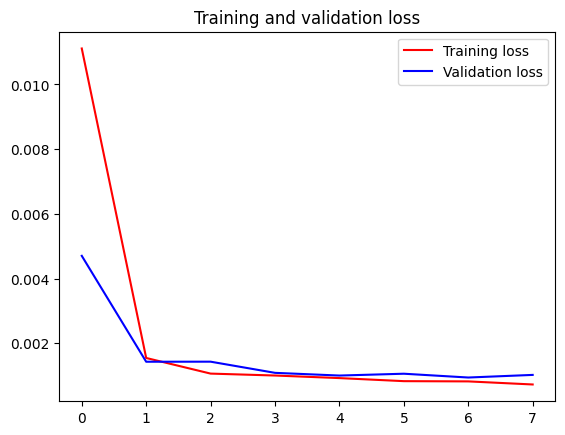

<Figure size 640x480 with 0 Axes>

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


((2485, 1), (1048, 1))

In [14]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [15]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3.291248505554888
Train data MSE:  10.832316725317286
Train data MAE:  2.0803547432053255
-------------------------------------------------------------------------------------
Test data RMSE:  3.75480750298642
Test data MSE:  14.098579384483116
Test data MAE:  2.448868508375328


In [16]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9566580835101586
Test data explained variance regression score: 0.9378570152251335


In [17]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9561932945916296
Test data R2 score: 0.9378540474509157


In [18]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.006227031923523996
Test data MGD:  0.005572893184347045
----------------------------------------------------------------------
Train data MPD:  0.23804810215169225
Test data MPD:  0.2648531276182256


In [19]:
import seaborn as sns

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))

# names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])
# colors = cycle(['blue', 'orange', 'green'])

# for col in ['original_close', 'train_predicted_close', 'test_predicted_close']:
#     plt.plot(plotdf['date'], plotdf[col], label=next(names), color=next(colors))

# plt.xlabel('Date')
# plt.ylabel('Stock price')
# plt.title('Comparison between Google Stock original close price vs Google Stock predicted close price')
# plt.xticks(rotation=45)
# plt.legend()

# plt.tight_layout()
# plt.show()


Train predicted data:  (3595, 1)
Test predicted data:  (3595, 1)


In [20]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30    # Prediction for next 30 days

while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [21]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60]


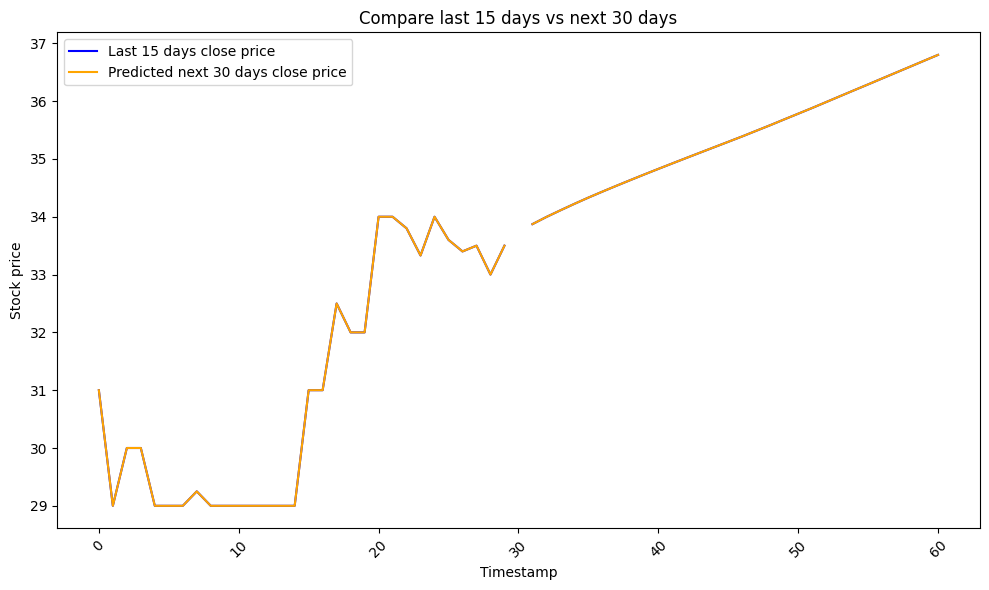

In [22]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])


# Assuming you have new_pred_plot DataFrame with necessary columns

plt.figure(figsize=(10, 6))

names = cycle(['Last 15 days close price', 'Predicted next 30 days close price'])
colors = cycle(['blue', 'orange'])

for col in ['last_original_days_value', 'next_predicted_days_value']:
    plt.plot(new_pred_plot.index, new_pred_plot[col], label=next(names), color=next(colors))

plt.xlabel('Timestamp')
plt.ylabel('Stock price')
plt.title('Compare last 15 days vs next 30 days')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


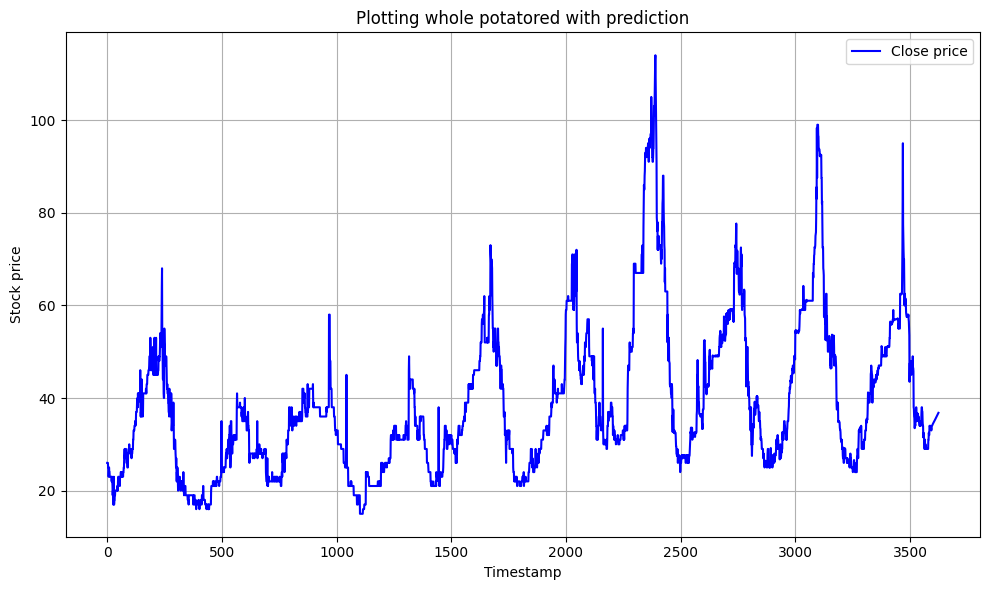

In [23]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])


# Assuming you have lstmdf list of stock prices

plt.figure(figsize=(10, 6))

names = cycle(['Close price'])
colors = cycle(['blue'])

plt.plot(lstmdf, label=next(names), color=next(colors))

plt.xlabel('Timestamp')
plt.ylabel('Stock price')
plt.title('Plotting whole potatored with prediction')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


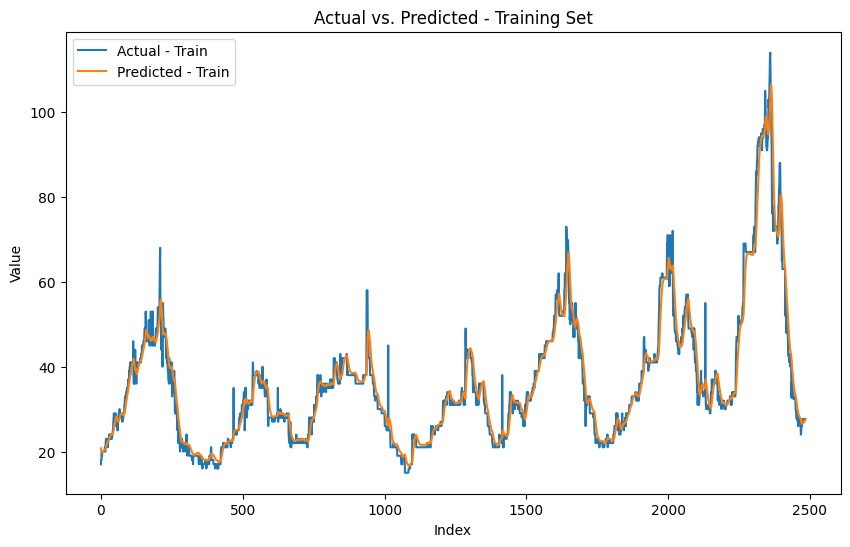

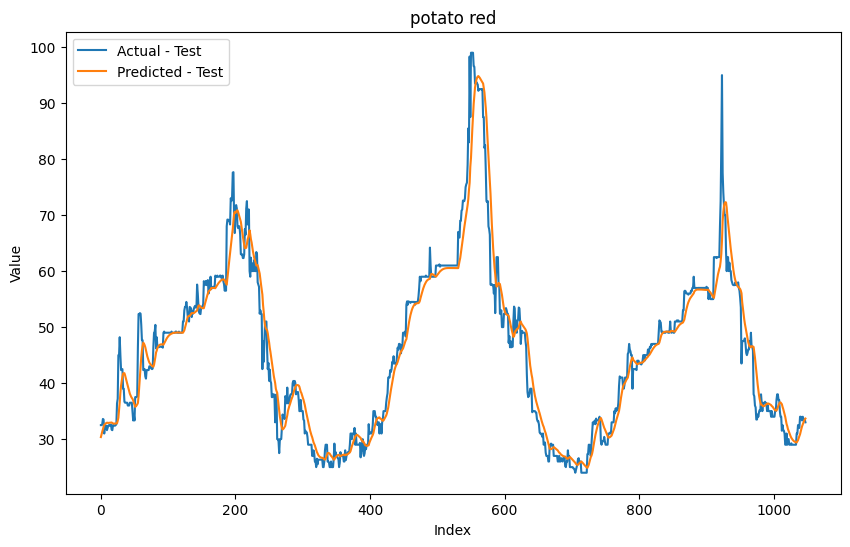

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(original_ytrain, label='Actual - Train')
plt.plot(train_predict, label='Predicted - Train')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs. Predicted - Training Set')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(original_ytest, label='Actual - Test')
plt.plot(test_predict, label='Predicted - Test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('potato red')
plt.legend()
plt.show()


In [25]:
print(next_predicted_days_value[:30])
print(len(next_predicted_days_value))


[31.0, 28.999999999999996, 30.0, 30.0, 28.999999999999996, 28.999999999999996, 28.999999999999996, 29.25, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 31.0, 31.0, 32.5, 32.0, 32.0, 34.0, 34.0, 33.8, 33.33, 34.0, 33.6, 33.4, 33.5, 33.0, 33.5]
61


In [26]:
predictedprices=next_predicted_days_value[:30]

In [27]:
from flask import Flask, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

print(predictedprices)
@app.route('/getPotatoValues', methods=['GET'])
def get_potato_values():
    # Ensure there are at least 3 values in the predicted_prices array
    if len(predictedprices) >= 3:
        potato_data = {
            "name": "potato",
            "currentPrice": predictedprices[0],
            "yesterdayPrice": predictedprices[1],
            "tomorrowPrice": predictedprices[2],
            "description": "This is potato",
            "locality": "Nepali",
        }
        return jsonify(potato_data)
    else:
        return jsonify({"error": "Not enough data available"}), 404

if __name__ == '__main__':
    app.run(port=27333)

[31.0, 28.999999999999996, 30.0, 30.0, 28.999999999999996, 28.999999999999996, 28.999999999999996, 29.25, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 31.0, 31.0, 32.5, 32.0, 32.0, 34.0, 34.0, 33.8, 33.33, 34.0, 33.6, 33.4, 33.5, 33.0, 33.5]
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:27333
Press CTRL+C to quit
127.0.0.1 - - [05/Mar/2024 12:29:38] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:29:38] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:01] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:01] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:03] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:03] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:21] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:21] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:44] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:51:44] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:52:00] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:52:00] "GET /getPotatoValues HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2024 12:52:28] "GET 